# 読み込むモデルの選択
2020年8月17日

In [1]:
from pathlib import Path
# checkpoint = Path('/').joinpath('workspace', 'outputs', '2020-07-29', '10-42-46')
checkpoint = Path('/').joinpath('workspace', 'outputs', '2020-08-15', '22-00-16')
checkpoint

PosixPath('/workspace/outputs/2020-08-15/22-00-16')

# 準備
2020年8月17日

In [2]:
import torch
import pytorch_lightning as pl
import torchvision
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
import hydra
import yaml
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm

In [3]:
from src.model import Encoder, Decoder
from src.integrated_model import IntegratedModel
from src.patch import make_patch2d

In [4]:
with open(checkpoint.joinpath('.hydra', 'config.yaml')) as file:
    config = hydra.utils.DictConfig(yaml.safe_load(file))
print(config)

{'callback': {'callbacks': None, 'checkpoint': {'class': 'pytorch_lightning.callbacks.ModelCheckpoint', 'params': {'filepath': None, 'mode': 'auto', 'monitor': 'val_loss', 'save_top_k': 1, 'verbose': False}}, 'early_stopping': {'class': 'pytorch_lightning.callbacks.EarlyStopping', 'params': {'min_delta': 0, 'mode': 'auto', 'monitor': 'val_loss', 'patience': '${hparams.early_stopping}', 'verbose': False}}}, 'dataset': {'class': 'src.dataset.adobe_font_char_images', 'params': {'lower': False, 'root': '/dataset/', 'upper': True}}, 'dataset_output_n': 52, 'debug': False, 'experiment_name': 'Default', 'hparams': {'batch_size': 1024, 'dataset_n': 0, 'dataset_n_splits': 5, 'early_stopping': 500, 'latent_dim': 2, 'lr': 0.001, 'max_epochs': 100000, 'min_epochs': 1, 'num_workers': 6, 'patch_size': 25, 'pooling_mode': 'sum', 'seed': 0, 'test_patch_n': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048], 'train_patch_n': [1, 2, 4, 8, 16, 32, 64], 'use_tanh': False, 'valid_patch_n': [1, 2, 4, 8, 16

In [5]:
encoder = Encoder(**config.model_params.encoder)
decoder = Decoder(**config.model_params.decoder)

In [6]:
import glob

model_checkpoint = glob.glob(str(checkpoint / '**' / '*.ckpt'), recursive=True)
assert len(model_checkpoint) == 1
model_checkpoint = model_checkpoint[0]

In [7]:
transform = torchvision.transforms.Compose([hydra.utils.instantiate(i) for i in config.transform]) if config.transform else None
# target_transform = torchvision.transforms.Compose([hydra.utils.instantiate(i) for i in config.target_transform]) if config.target_transform else None
target_transform = None

____, dataset = hydra.utils.instantiate(config.dataset)
dataset.set_transform(transform, target_transform)

100%|██████████| 4914/4914 [00:00<00:00, 28144.81it/s]


In [8]:
model = IntegratedModel.load_from_checkpoint(model_checkpoint, encoder=encoder, decoder=decoder, optim=None, dataset=dataset)
model

IntegratedModel(
  (encoder): Encoder(
    (fc0): Linear(in_features=625, out_features=256, bias=True)
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc0): Linear(in_features=2, out_features=256, bias=True)
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=52, bias=True)
  )
)

# 白，黒，ランダムの平均，分散，ノルム
2020年8月17日

In [9]:
pl.seed_everything(0)
patch_size = config.hparams.patch_size

patch = torch.zeros([1, 100, 1, patch_size, patch_size])
a = model.pooling(encoder(patch[:, :1]))
print(a.mean().item(), a.var().item(), a.norm().item())
a = model.pooling(encoder(patch[:, :10]))
print(a.mean().item(), a.var().item(), a.norm().item())
a = model.pooling(encoder(patch[:, :100]))
print(a.mean().item(), a.var().item(), a.norm().item())

print()

patch = torch.ones([1, 100, 1, patch_size, patch_size])
a = model.pooling(encoder(patch[:, :1]))
print(a.mean().item(), a.var().item(), a.norm().item())
a = model.pooling(encoder(patch[:, :10]))
print(a.mean().item(), a.var().item(), a.norm().item())
a = model.pooling(encoder(patch[:, :100]))
print(a.mean().item(), a.var().item(), a.norm().item())

print()

patch = torch.rand([1, 100, 1, patch_size, patch_size])
a = model.pooling(encoder(patch[:, :1]))
print(a.mean().item(), a.var().item(), a.norm().item())
a = model.pooling(encoder(patch[:, :10]))
print(a.mean().item(), a.var().item(), a.norm().item())
a = model.pooling(encoder(patch[:, :100]))
print(a.mean().item(), a.var().item(), a.norm().item())


-0.016881899908185005 0.00023295059509109706 0.028336333110928535
-0.16881899535655975 0.02329506166279316 0.28336331248283386
-1.6881896257400513 2.3295042514801025 2.833632469177246

-0.02007538639008999 0.0004568189615383744 0.0355367586016655
-0.20075388252735138 0.0456819050014019 0.35536763072013855
-2.007539749145508 4.568192958831787 3.553677558898926

-0.0017917894292622805 2.239674904558342e-05 0.005368218291550875
-0.01768188178539276 0.0021239386405795813 0.052433162927627563
-0.1488061398267746 0.10920357704162598 0.3917781412601471


# パッチと分類結果
2020年8月17日

189.0
0 AGaramondPro-BoldItalic capA


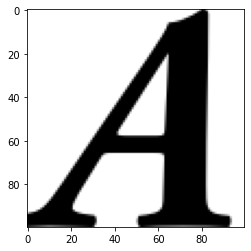


(true_class == predicted_class).item()=True
capA 0.9918915033340454
capA 0.9918915033340454


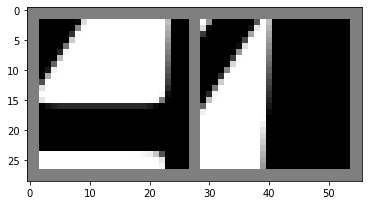


(true_class == predicted_class).item()=True
capA 0.9971869587898254
capA 0.9971869587898254


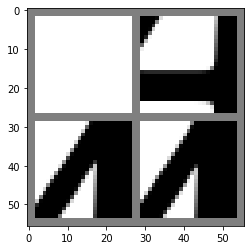


(true_class == predicted_class).item()=True
capA 0.9990947246551514
capA 0.9990947246551514


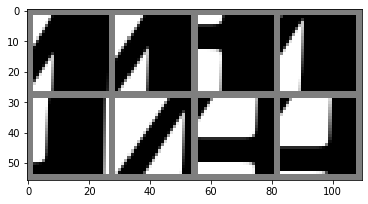


1 AGaramondPro-BoldItalic capB


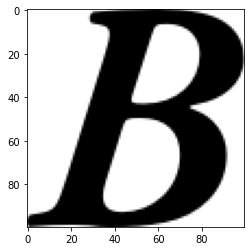


(true_class == predicted_class).item()=True
capB 0.8708086609840393
capB 0.8708086609840393


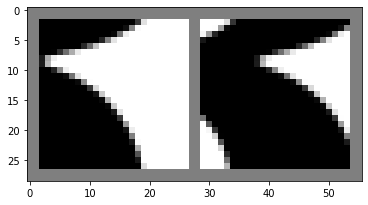


(true_class == predicted_class).item()=True
capB 0.9034774303436279
capB 0.9034774303436279


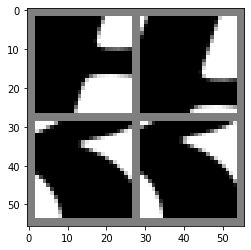


(true_class == predicted_class).item()=True
capB 0.9312549829483032
capB 0.9312549829483032


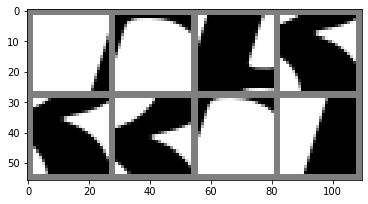


2 AGaramondPro-BoldItalic capC


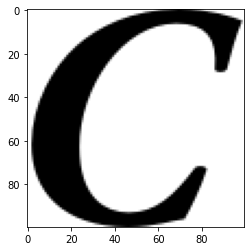


(true_class == predicted_class).item()=True
capC 0.7493953704833984
capC 0.7493953704833984


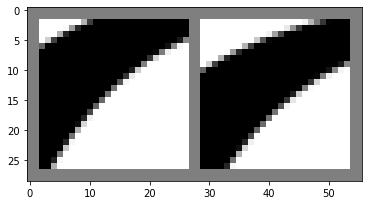


(true_class == predicted_class).item()=True
capC 0.8101993203163147
capC 0.8101993203163147


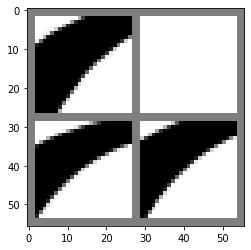


(true_class == predicted_class).item()=True
capC 0.7420492768287659
capC 0.7420492768287659


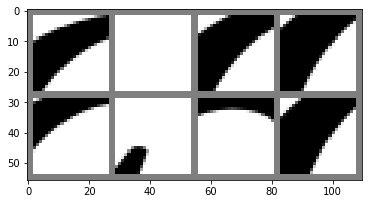


3 AGaramondPro-BoldItalic capD


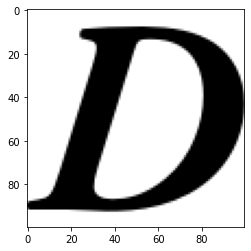


(true_class == predicted_class).item()=True
capD 0.9120641350746155
capD 0.9120641350746155


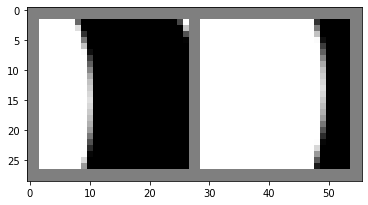


(true_class == predicted_class).item()=True
capD 0.9292623400688171
capD 0.9292623400688171


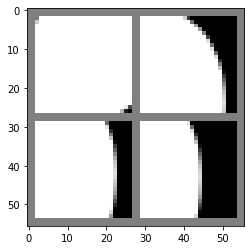


(true_class == predicted_class).item()=True
capD 0.9395238161087036
capD 0.9395238161087036


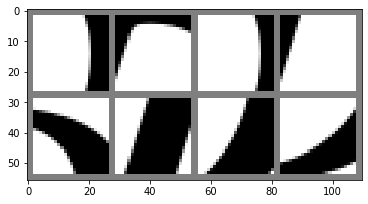


4 AGaramondPro-BoldItalic capE


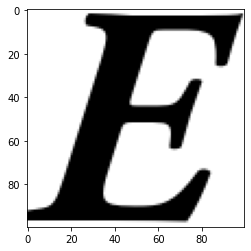


(true_class == predicted_class).item()=True
capE 0.5633230209350586
capE 0.5633230209350586


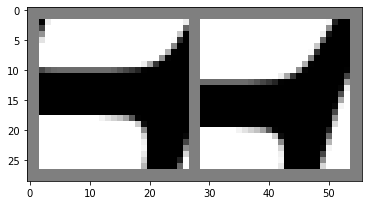


(true_class == predicted_class).item()=True
capE 0.5442119240760803
capE 0.5442119240760803


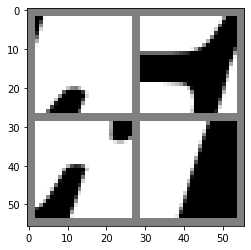


(true_class == predicted_class).item()=True
capE 0.6847378611564636
capE 0.6847378611564636


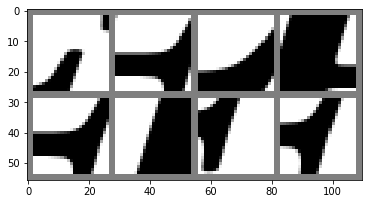


5 AGaramondPro-BoldItalic capF


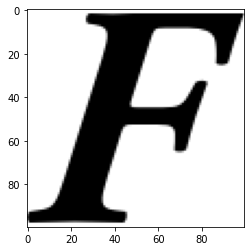


(true_class == predicted_class).item()=False
capF 0.4346613585948944
capE 0.5599504709243774


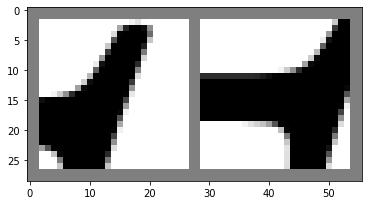


(true_class == predicted_class).item()=True
capF 0.5209847092628479
capF 0.5209847092628479


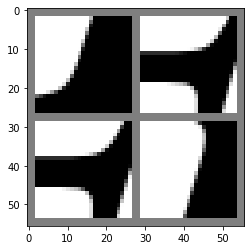


(true_class == predicted_class).item()=True
capF 0.5052937865257263
capF 0.5052937865257263


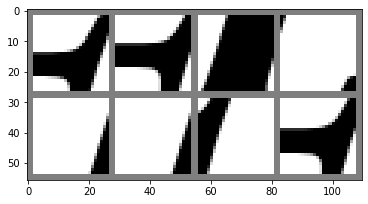


6 AGaramondPro-BoldItalic capG


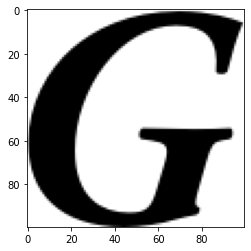


(true_class == predicted_class).item()=False
capG 0.20723307132720947
capC 0.7708613276481628


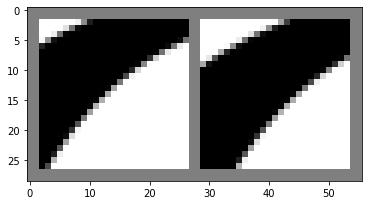


(true_class == predicted_class).item()=False
capG 0.24602064490318298
capC 0.7472745776176453


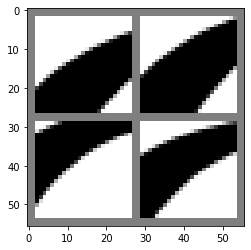


(true_class == predicted_class).item()=False
capG 0.3192489743232727
capC 0.6783083081245422


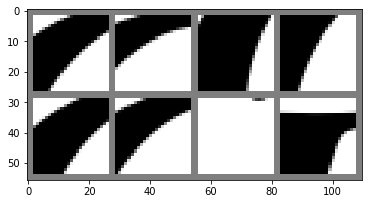


7 AGaramondPro-BoldItalic capH


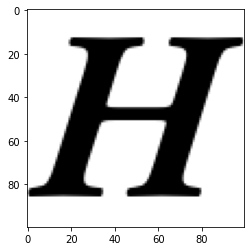


(true_class == predicted_class).item()=True
capH 0.995098888874054
capH 0.995098888874054


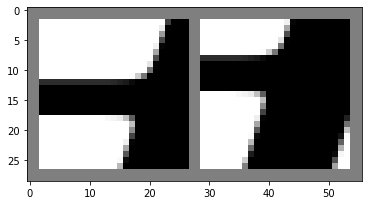


(true_class == predicted_class).item()=True
capH 0.9975119829177856
capH 0.9975119829177856


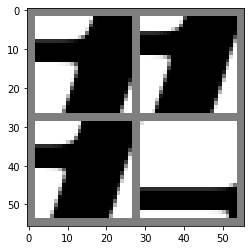


(true_class == predicted_class).item()=True
capH 0.9990845918655396
capH 0.9990845918655396


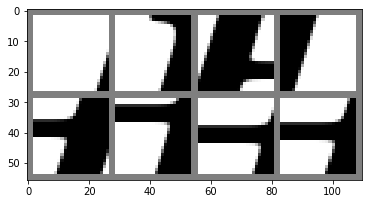


8 AGaramondPro-BoldItalic capI


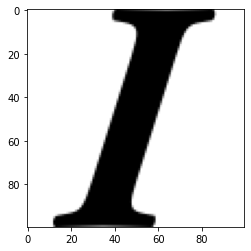


(true_class == predicted_class).item()=True
capI 0.30472683906555176
capI 0.30472683906555176


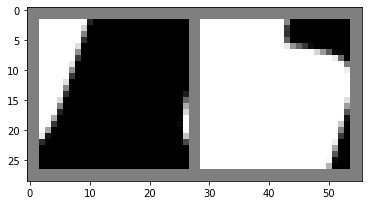


(true_class == predicted_class).item()=True
capI 0.3745438754558563
capI 0.3745438754558563


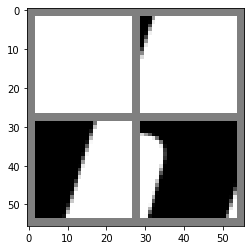


(true_class == predicted_class).item()=True
capI 0.5830838084220886
capI 0.5830838084220886


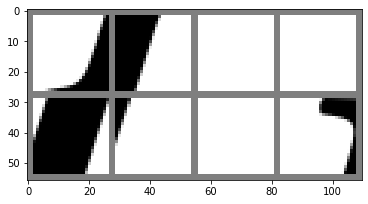


9 AGaramondPro-BoldItalic capJ


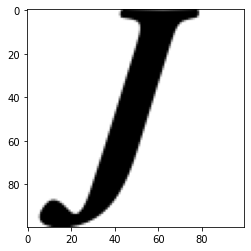


(true_class == predicted_class).item()=True
capJ 0.5386779308319092
capJ 0.5386779308319092


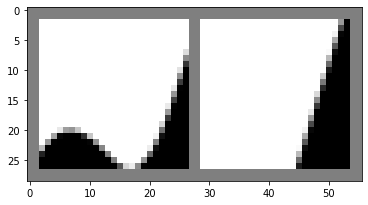


(true_class == predicted_class).item()=True
capJ 0.8226152062416077
capJ 0.8226152062416077


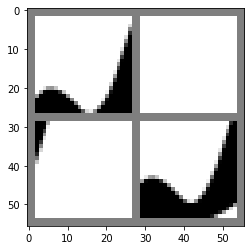


(true_class == predicted_class).item()=True
capJ 0.8835901618003845
capJ 0.8835901618003845


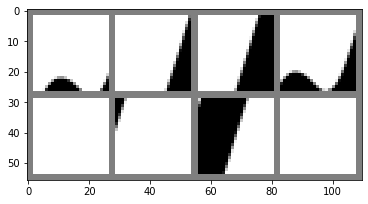


10 AGaramondPro-BoldItalic capK


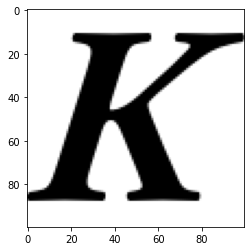


(true_class == predicted_class).item()=True
capK 0.996323823928833
capK 0.996323823928833


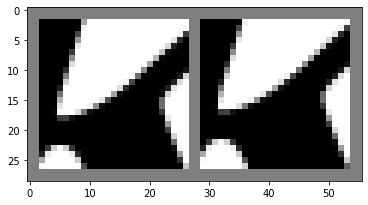


(true_class == predicted_class).item()=True
capK 0.9976842403411865
capK 0.9976842403411865


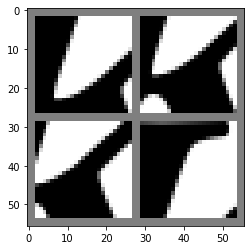


(true_class == predicted_class).item()=True
capK 0.9985920786857605
capK 0.9985920786857605


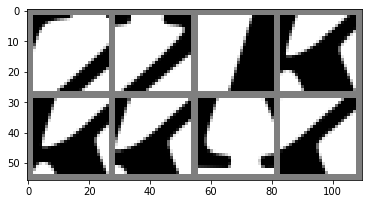


11 AGaramondPro-BoldItalic capL


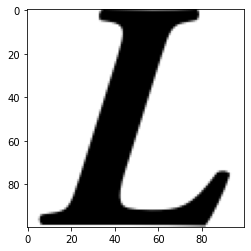


(true_class == predicted_class).item()=False
capL 0.14833171665668488
capI 0.29357171058654785


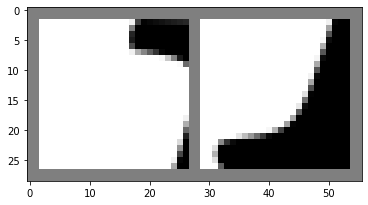


(true_class == predicted_class).item()=False
capL 0.18517066538333893
capU 0.2717796564102173


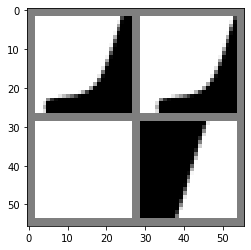


(true_class == predicted_class).item()=False
capL 0.15706977248191833
capI 0.5800263285636902


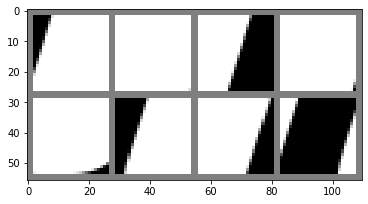


12 AGaramondPro-BoldItalic capM


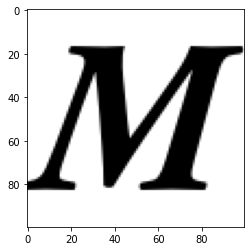


(true_class == predicted_class).item()=True
capM 0.9903821349143982
capM 0.9903821349143982


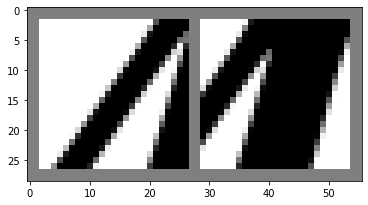


(true_class == predicted_class).item()=True
capM 0.9969775676727295
capM 0.9969775676727295


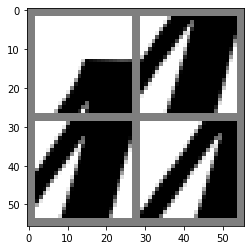


(true_class == predicted_class).item()=True
capM 0.9999151229858398
capM 0.9999151229858398


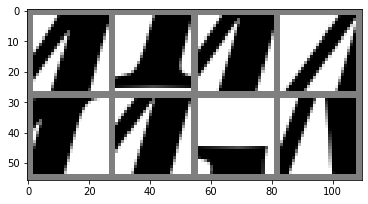


13 AGaramondPro-BoldItalic capN


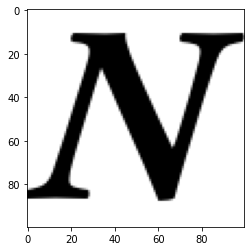


(true_class == predicted_class).item()=True
capN 0.979189395904541
capN 0.979189395904541


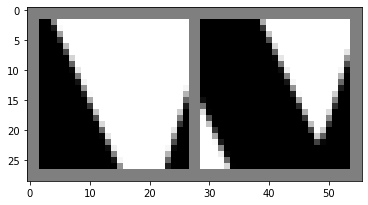


(true_class == predicted_class).item()=True
capN 0.9917299151420593
capN 0.9917299151420593


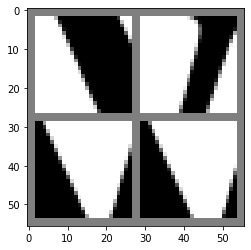


(true_class == predicted_class).item()=True
capN 0.9898731708526611
capN 0.9898731708526611


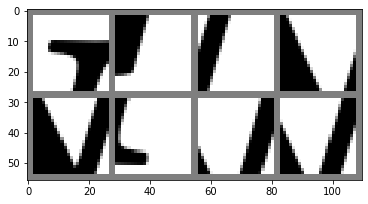


14 AGaramondPro-BoldItalic capO


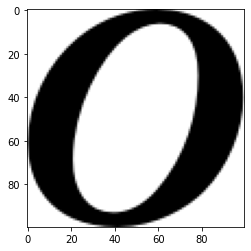


(true_class == predicted_class).item()=False
capO 0.016093077138066292
capC 0.8426156640052795


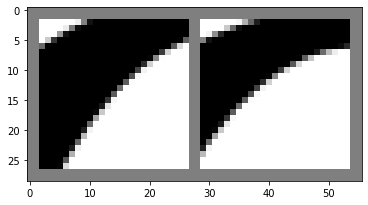


(true_class == predicted_class).item()=False
capO 0.0409964844584465
capC 0.8265480995178223


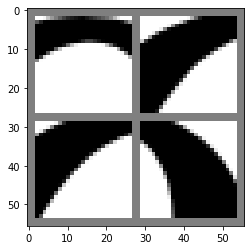


(true_class == predicted_class).item()=False
capO 0.0052942633628845215
capC 0.9119545221328735


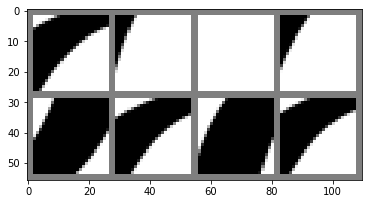


15 AGaramondPro-BoldItalic capP


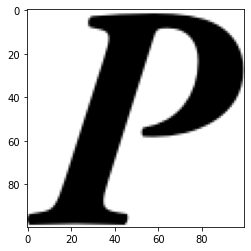


(true_class == predicted_class).item()=True
capP 0.9977432489395142
capP 0.9977432489395142


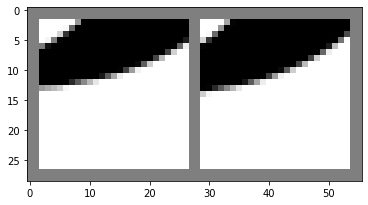


(true_class == predicted_class).item()=True
capP 0.9986804127693176
capP 0.9986804127693176


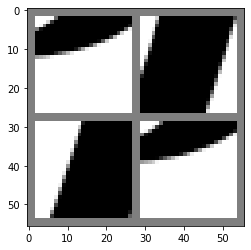


(true_class == predicted_class).item()=True
capP 0.9989863038063049
capP 0.9989863038063049


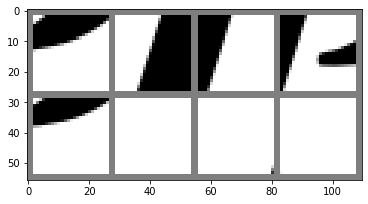


16 AGaramondPro-BoldItalic capQ


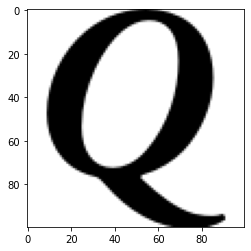


(true_class == predicted_class).item()=True
capQ 0.9942441582679749
capQ 0.9942441582679749


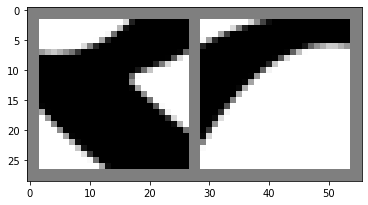


(true_class == predicted_class).item()=True
capQ 0.9996998310089111
capQ 0.9996998310089111


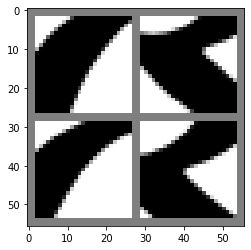


(true_class == predicted_class).item()=True
capQ 0.9999895095825195
capQ 0.9999895095825195


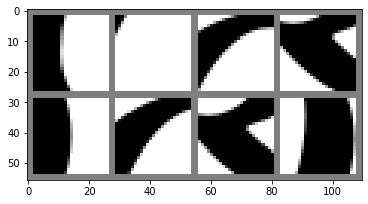


17 AGaramondPro-BoldItalic capR


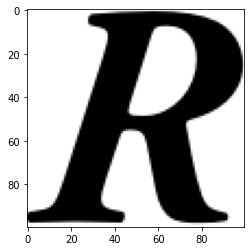


(true_class == predicted_class).item()=True
capR 0.8855611085891724
capR 0.8855611085891724


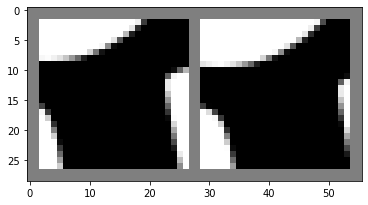


(true_class == predicted_class).item()=True
capR 0.9135253429412842
capR 0.9135253429412842


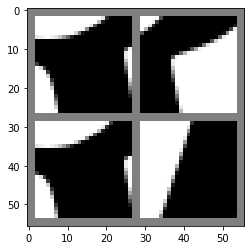


(true_class == predicted_class).item()=True
capR 0.8940343260765076
capR 0.8940343260765076


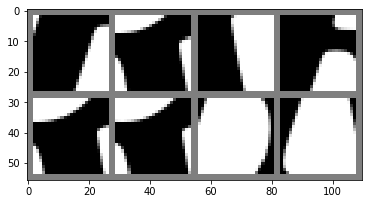


18 AGaramondPro-BoldItalic capS


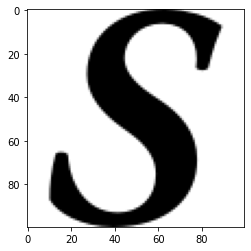


(true_class == predicted_class).item()=True
capS 0.9988266825675964
capS 0.9988266825675964


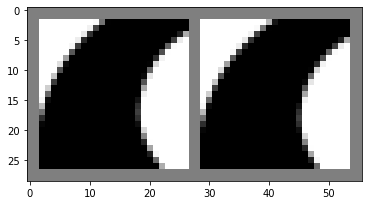


(true_class == predicted_class).item()=True
capS 0.9995039701461792
capS 0.9995039701461792


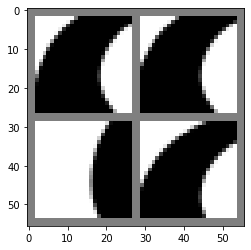


(true_class == predicted_class).item()=True
capS 0.9995114803314209
capS 0.9995114803314209


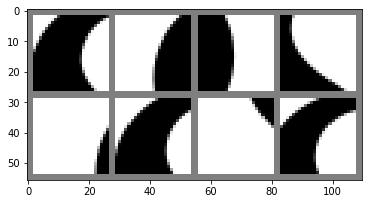


19 AGaramondPro-BoldItalic capT


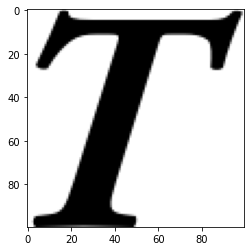


(true_class == predicted_class).item()=True
capT 0.8663889169692993
capT 0.8663889169692993


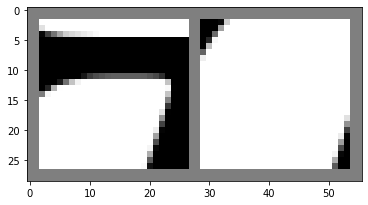


(true_class == predicted_class).item()=True
capT 0.9620503783226013
capT 0.9620503783226013


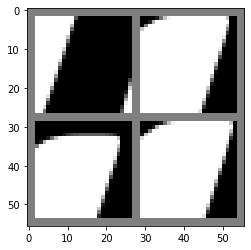


(true_class == predicted_class).item()=True
capT 0.9818707704544067
capT 0.9818707704544067


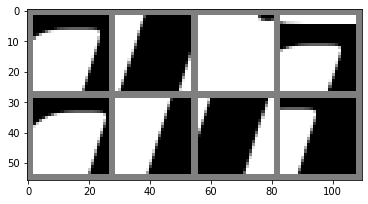


20 AGaramondPro-BoldItalic capU


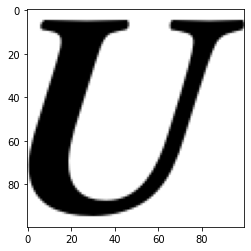


(true_class == predicted_class).item()=True
capU 0.35424286127090454
capU 0.35424286127090454


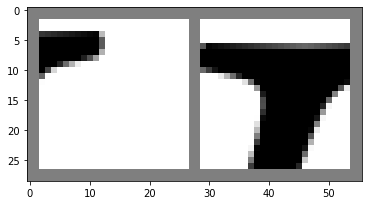


(true_class == predicted_class).item()=True
capU 0.6202588081359863
capU 0.6202588081359863


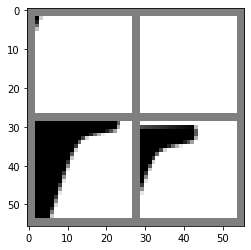


(true_class == predicted_class).item()=True
capU 0.8850539922714233
capU 0.8850539922714233


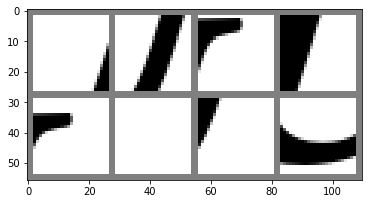


21 AGaramondPro-BoldItalic capV


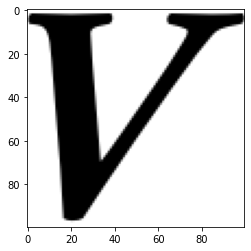


(true_class == predicted_class).item()=True
capV 0.9427819848060608
capV 0.9427819848060608


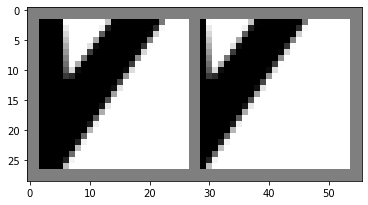


(true_class == predicted_class).item()=True
capV 0.9713206887245178
capV 0.9713206887245178


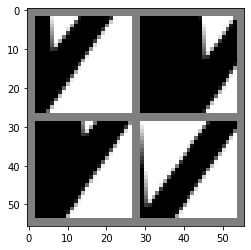


(true_class == predicted_class).item()=True
capV 0.9767688512802124
capV 0.9767688512802124


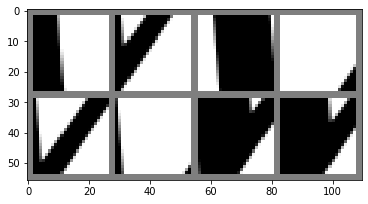


22 AGaramondPro-BoldItalic capW


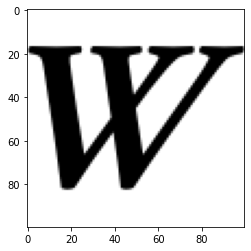


(true_class == predicted_class).item()=True
capW 0.920798122882843
capW 0.920798122882843


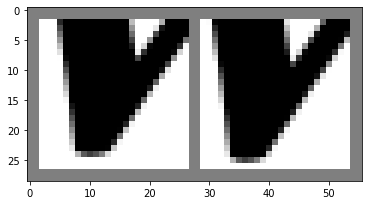


(true_class == predicted_class).item()=True
capW 0.9365259408950806
capW 0.9365259408950806


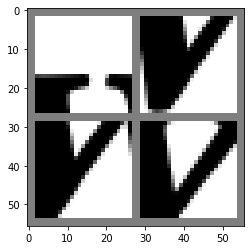


(true_class == predicted_class).item()=True
capW 0.9774866700172424
capW 0.9774866700172424


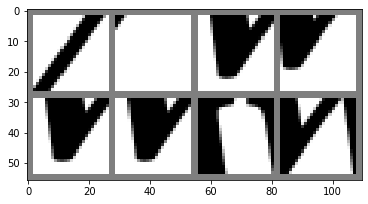


23 AGaramondPro-BoldItalic capX


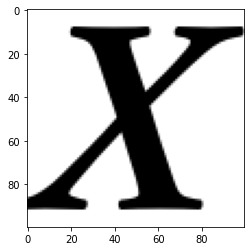


(true_class == predicted_class).item()=True
capX 0.9992840886116028
capX 0.9992840886116028


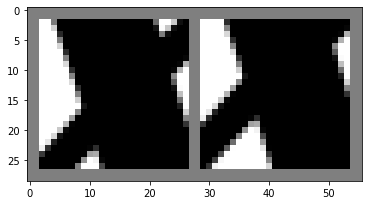


(true_class == predicted_class).item()=True
capX 0.9999700784683228
capX 0.9999700784683228


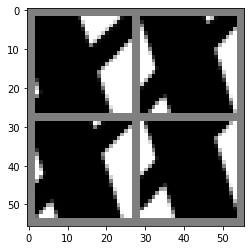


(true_class == predicted_class).item()=True
capX 0.9999957084655762
capX 0.9999957084655762


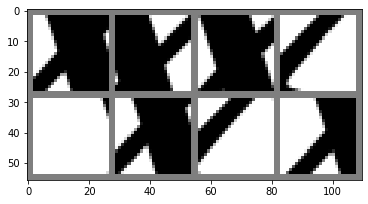


24 AGaramondPro-BoldItalic capY


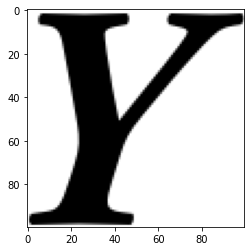


(true_class == predicted_class).item()=True
capY 0.9921940565109253
capY 0.9921940565109253


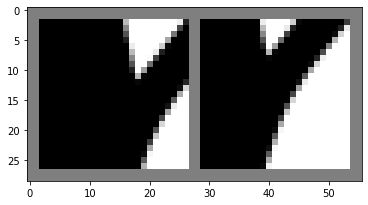


(true_class == predicted_class).item()=True
capY 0.9982061386108398
capY 0.9982061386108398


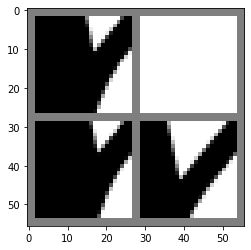


(true_class == predicted_class).item()=True
capY 0.9996563196182251
capY 0.9996563196182251


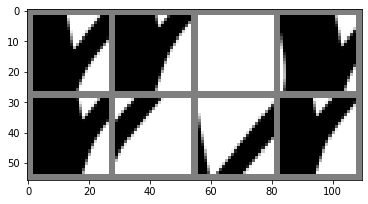


25 AGaramondPro-BoldItalic capZ


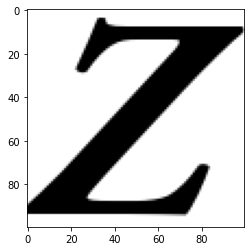


(true_class == predicted_class).item()=True
capZ 0.9968698620796204
capZ 0.9968698620796204


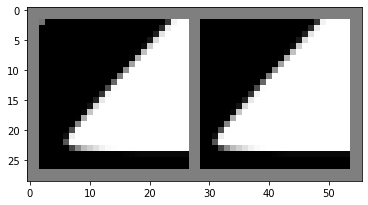


(true_class == predicted_class).item()=True
capZ 0.9990991353988647
capZ 0.9990991353988647


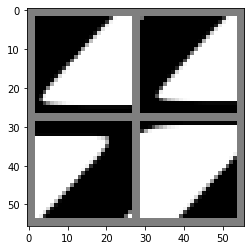


(true_class == predicted_class).item()=True
capZ 0.9997300505638123
capZ 0.9997300505638123


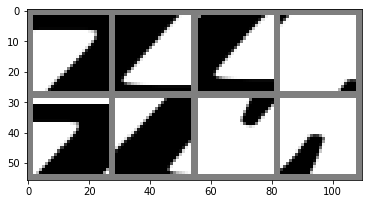

In [10]:
pl.seed_everything(0)
print(len(dataset) / 26)
with torch.no_grad():
    for i, (image, t) in zip(range(26 * 1), dataset):
        font = t['font']
        class_ = t['alphabet']
        print(i, dataset.unique_font[font], dataset.unique_alphabet[class_])
        plt.imshow(to_pil_image(image), 'gray')
        plt.show()
        print()
        x = image[None].expand([2**16, -1, -1, -1])
        for patch_n, nrow in zip(*zip([2, 2], [4, 2], [8, 4])):
            patch = make_patch2d(x, config.hparams.patch_size, patch_n)
            y = model(patch)
            max_index = y[:, class_].argmax()

            true_class = class_
            true_prob = y[max_index].softmax(0)[class_].item()
            predicted_class = y[max_index].argmax(0)
            predicted_prob = y[max_index].softmax(0)[predicted_class].item()
            
            print(f'(true_class == predicted_class).item()={(true_class == predicted_class).item()}')
            print(dataset.unique_alphabet[true_class], true_prob)
            print(dataset.unique_alphabet[predicted_class], predicted_prob)
            plt.imshow(to_pil_image(make_grid(patch[max_index], nrow=nrow, pad_value=0.5)))
            plt.show()
            print()

# パッチのノルム
2020年8月17日

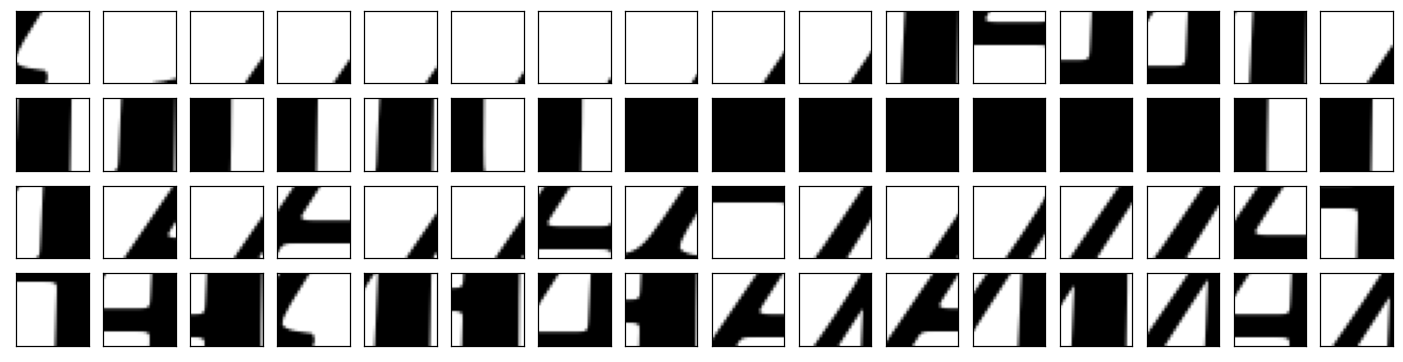

[[[   0.00726    0.01256    0.01382    0.01423    0.01509    0.01517    0.01619    0.01636    0.02085    0.02361    0.02435    0.02523    0.02566    0.02632    0.02781    0.02981]
  [   0.02983    0.03173    0.03202    0.03315    0.0338     0.03452    0.03454    0.03554    0.03554    0.03554    0.03554    0.03554    0.03554    0.03554    0.03569    0.0375 ]
  [   0.03848    0.04903    0.05454    0.07916    0.08107    0.10236    0.11573    0.11836    0.13394    0.15098    0.15433    0.17895    0.28996    0.29133    0.42259    0.46666]
  [   0.55195    1.81084    4.53059    4.70945    5.63643    9.09539   12.15744   17.94313   23.82417   25.61783   26.82063   34.91623   35.01543   47.80798   75.47389   89.50509]]

 [[  36.9974  -110.80941  -65.27704  -67.80129  -80.65879  -93.13986 -105.5505   -96.25468  -45.40322  -46.29644 -127.32601  114.31204 -115.27335 -175.24228 -108.58197  -48.22529]
  [-109.87768 -114.48444 -107.69077 -107.23897 -107.32713 -106.70251 -107.17651  -98.0267   -98.02

In [11]:
pl.seed_everything(0)
with torch.no_grad():
    x = dataset[0][0][None]
    patch_list = make_patch2d(x, config.hparams.patch_size, 64)[0]
    latent = encoder(patch_list)
    index = latent.norm(dim=[1, 2]).argsort()

    patch_list = patch_list[index]
    latent = latent[index]

    fig, ax_list = plt.subplots(4, 16, figsize=[16, 4], dpi=111)
    for ax, patch in zip(ax_list.flatten(), patch_list):
        ax.imshow(to_pil_image(patch), 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

    tmp = np.get_printoptions()
    np.set_printoptions(precision=5, suppress=True, linewidth=np.inf)
    print(torch.stack([
        latent.norm(dim=[1, 2]),
        torch.atan2(*latent[:, 0].T) * 180 / np.pi,
    ]).numpy().reshape(-1, 4, 16))
    print(np.array([f'    {i[3:]}   ' for i in dataset.unique_alphabet])[decoder(latent[:, 0]).argmax(1)].reshape(4, 16))
    np.set_printoptions(**tmp)

# Decoderの分布可視化
2020年8月17日

0.01


26it [00:00, 576.53it/s]


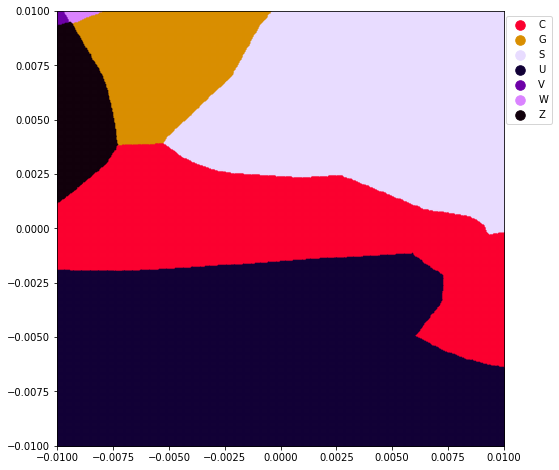

0.1


26it [00:00, 400.49it/s]


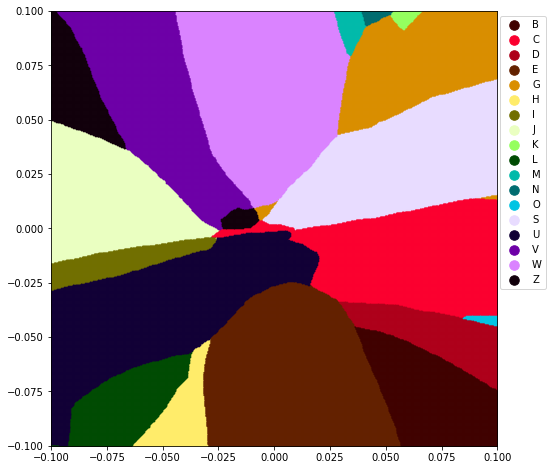

1


26it [00:00, 319.48it/s]


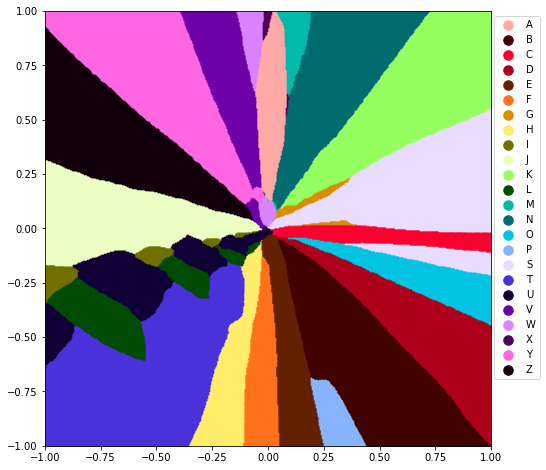

10


26it [00:00, 322.41it/s]


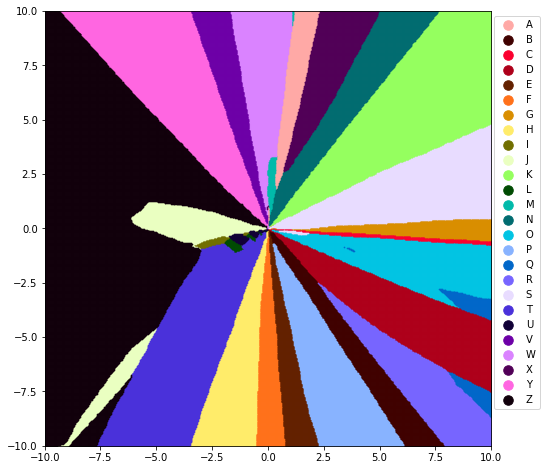

100


26it [00:00, 319.95it/s]


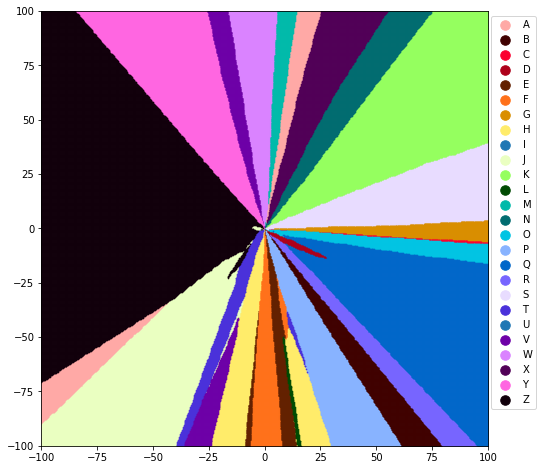

In [12]:
cmap = np.array([[255,169,166], [64,1,0], [251,0,47], [174,0,26], [99,33,0], [255,113,26], [217,142,0], [255,236,106], [113,111,0], [234,255,193], [149,255,95], [0,75,2], [1,186,170], [1,108,112], [1,196,227], [136,179,255], [1,103,201], [119,101,255], [232,220,255], [74,49,218], [17,0,54], [109,0,167], [218,131,255], [81,0,87], [255,102,225], [17,0,11]]
    ) / 0xff
s = 0.4
markerscale = 15
with torch.no_grad():
    for scale in [0.01, 0.1, 1, 10, 100]:
        print(scale)
        grid = torch.stack(torch.meshgrid([torch.linspace(-scale, scale, 500)]*2)).T.reshape([-1, 2])
        y_hat = decoder(grid)
        class_ = y_hat.argmax(1)
        
        plt.figure(figsize=[8, 8])
        for i, (alphabet, c) in tqdm(enumerate(zip(dataset.unique_alphabet, cmap)), leave=True):
            if (class_ != i).all():
                continue
            plt.scatter(*grid[class_ == i].T, label=alphabet[-1:], s=s, c=[c])
        plt.legend(bbox_to_anchor=(1.12, 1), markerscale=markerscale)
        plt.xlim(-scale, scale)
        plt.ylim(-scale, scale)
        plt.grid(False)
        plt.show()

# Decoderのエントロピー可視化
2020年8月17日

0.01


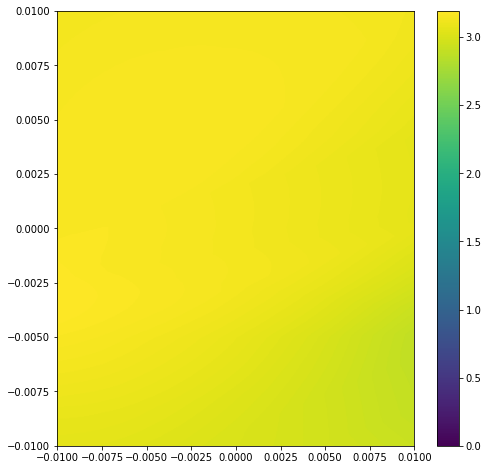

0.1


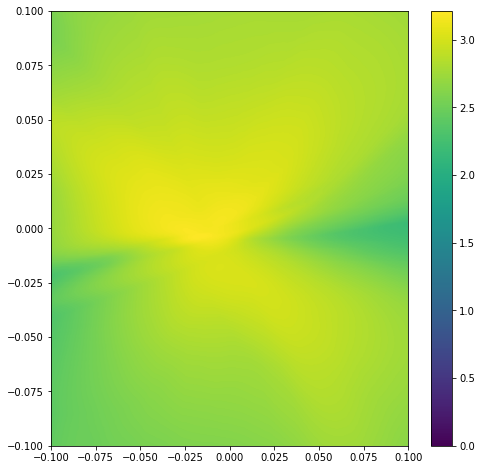

1


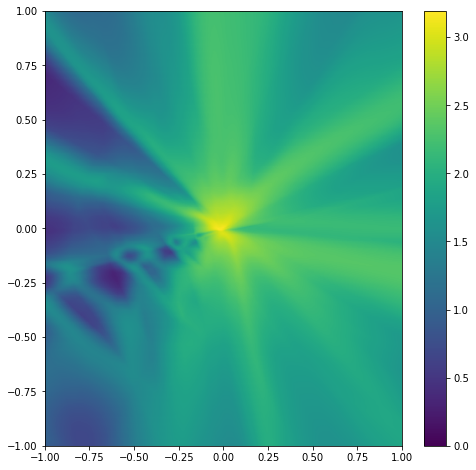

10


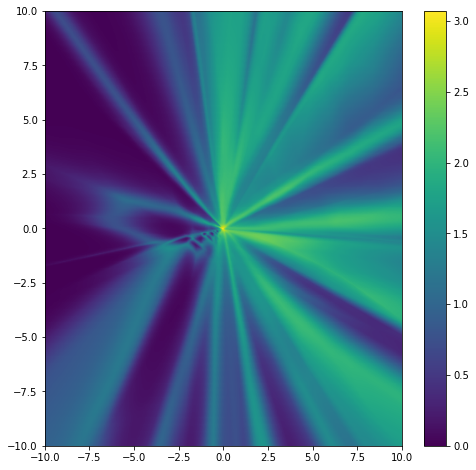

100


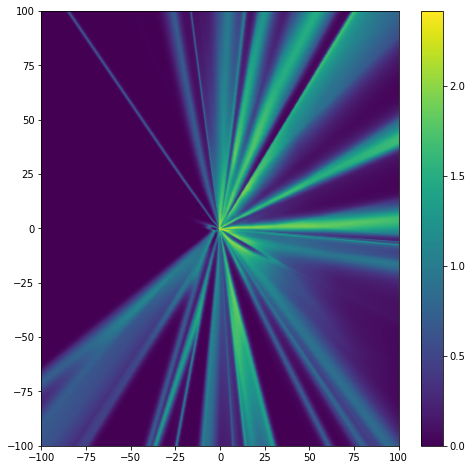

In [13]:
cmap_all = plt.get_cmap('gist_ncar', len(dataset.unique_alphabet))
cmap = plt.get_cmap('tab10')
s = 0.4
markerscale = 15
with torch.no_grad():
    for scale in [0.01, 0.1, 1, 10, 100]:
        print(scale)
        grid = torch.stack(torch.meshgrid([torch.linspace(-scale, scale, 500)]*2)).T.reshape([-1, 2])
        y_hat = decoder(grid)
        entropy = -(y_hat.softmax(1) * y_hat.log_softmax(1)).sum(1)
        
        plt.figure(figsize=[8, 8])
        plt.scatter(*grid.T, s=s, c=entropy, vmin=0, vmax=entropy.max())
        plt.colorbar()
        plt.xlim(-scale, scale)
        plt.ylim(-scale, scale)
        plt.grid(False)
        plt.show()